## 순환신경망(RNN)

순환하기 위해서는 닫힌 경로가 필요하다.
닫힌 경로 혹은 순환하는 경로가 존재해야 데이터가 같은 장소를 반복해 왕래할 수 있고 데이터가 순환하면서 과거의 정보를 기억하는 동시에 최신 데이터로 갱신 될 수 있다.

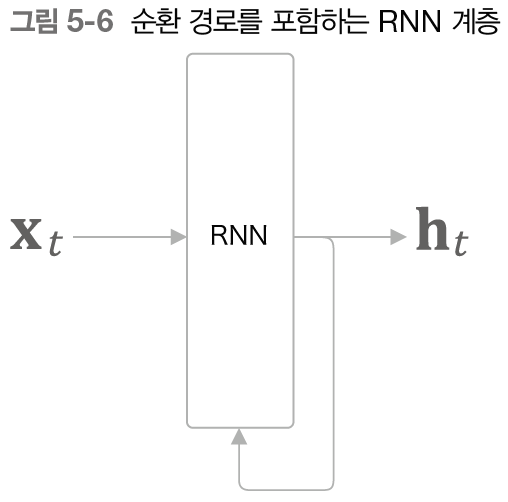

t: 시각
시계열 데이터(x0, x1,...xt, ...)가 RNN계층에 입력되고 이에 대응해 (h0, h1, ..., ht, ...)가 출력된다.
각 시각에 입력되는 xt를 벡터라고 가정했을 때
문장(단어 순서)을 다루는 경우를 예로 든다면 각 단어의 분산 표현(단어 벡터)이 xt가 되며 이 분산 표현이 순서대로 하나씩 RNN계층에 입력된다.

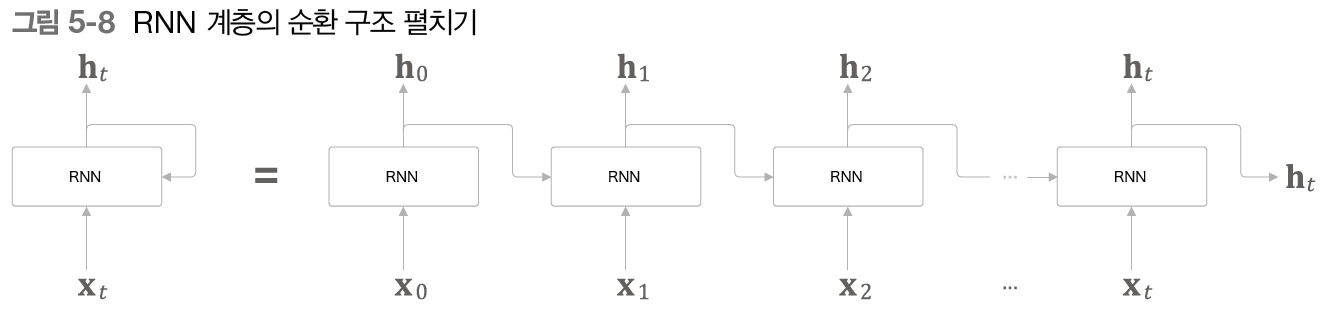

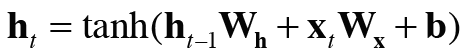

ht는 다른 계층을 향해 위쪽으로 출력되는 동시에 다음 시각의 RNN계층(자기 자신)을 향해 오른쪽으로도 출력된다. RNN의 출력 ht는 은닉상태(hidden state) 혹은 은닉 상태 벡터(hidden state vector)라고 한다.

RNN은 h라는 '상태'를 가지고 있으며 위의 식의 형태로 갱신된다고 해석할 수 있다.
RNN계층을 '상태를 가지는 계층' 혹은 '메모리(기억력)가 있는 계층'이라고 한다.

## BPTT

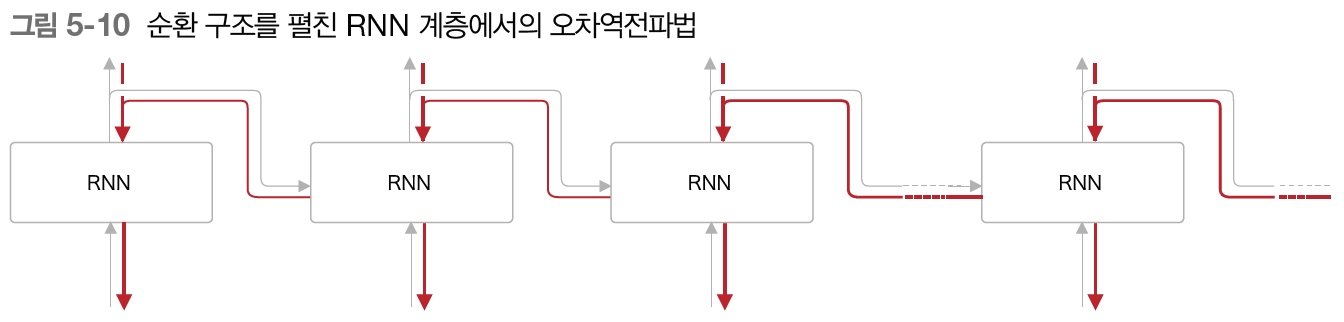


## Truncated BPTT

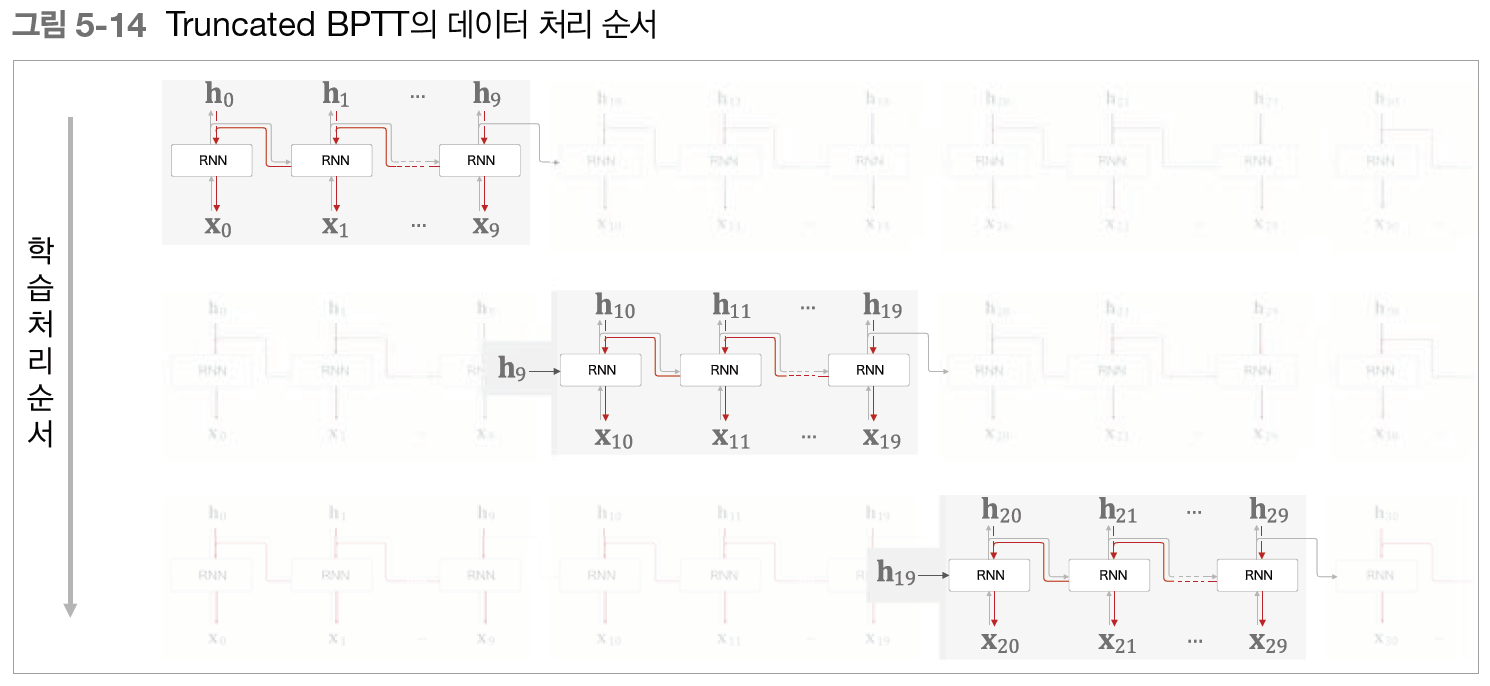

Truncated BPTT : 시간축 방향으로 너무 길어진 신경망을 적당한 지점에서 잘라내어 작은 신경망 여러 개로 만들어 잘라낸 작은 신경망에서 오차역전파법을 수행한다.

계층이 너무 길면 계산량과 메모리 사용량 등이 문제가 되고 계층이 길어짐에 따라 신경망을 하나 통과할 때마다 기울기 값이 조금씩 작아져서 이전 시각 t까지 역전파되기 전에 0이 되어 소멸할 수도 있다.
순전파의 연결을 그대로 유지하면서(데이터를 순서대로 입력해야 한다) 역전파의 연결은 적당한 길이로 잘라내 잘라낸 신경망 단위로 학습을 수행한다.
역전파의 연결을 잘라버리면 그보다 미래의 데이터에 대해서는 생각할 필요가 없어지기 때문에 각각의 블록 단위로 미래의 블록과는 독립적으로 오차역전파법을 완결시킨다.
- 블록: 역전파가 연결되는 일련의 RNN계층
순전파를 수행하고 그 다음 역전파를 수행하여 원하는 기울기를 구한다.
다음 역전파를 수행할 때 앞 블록의 마지막 은닉 상태인 ht가 필요하다.
ht로 순전파가 계속 연결될 수 있다.

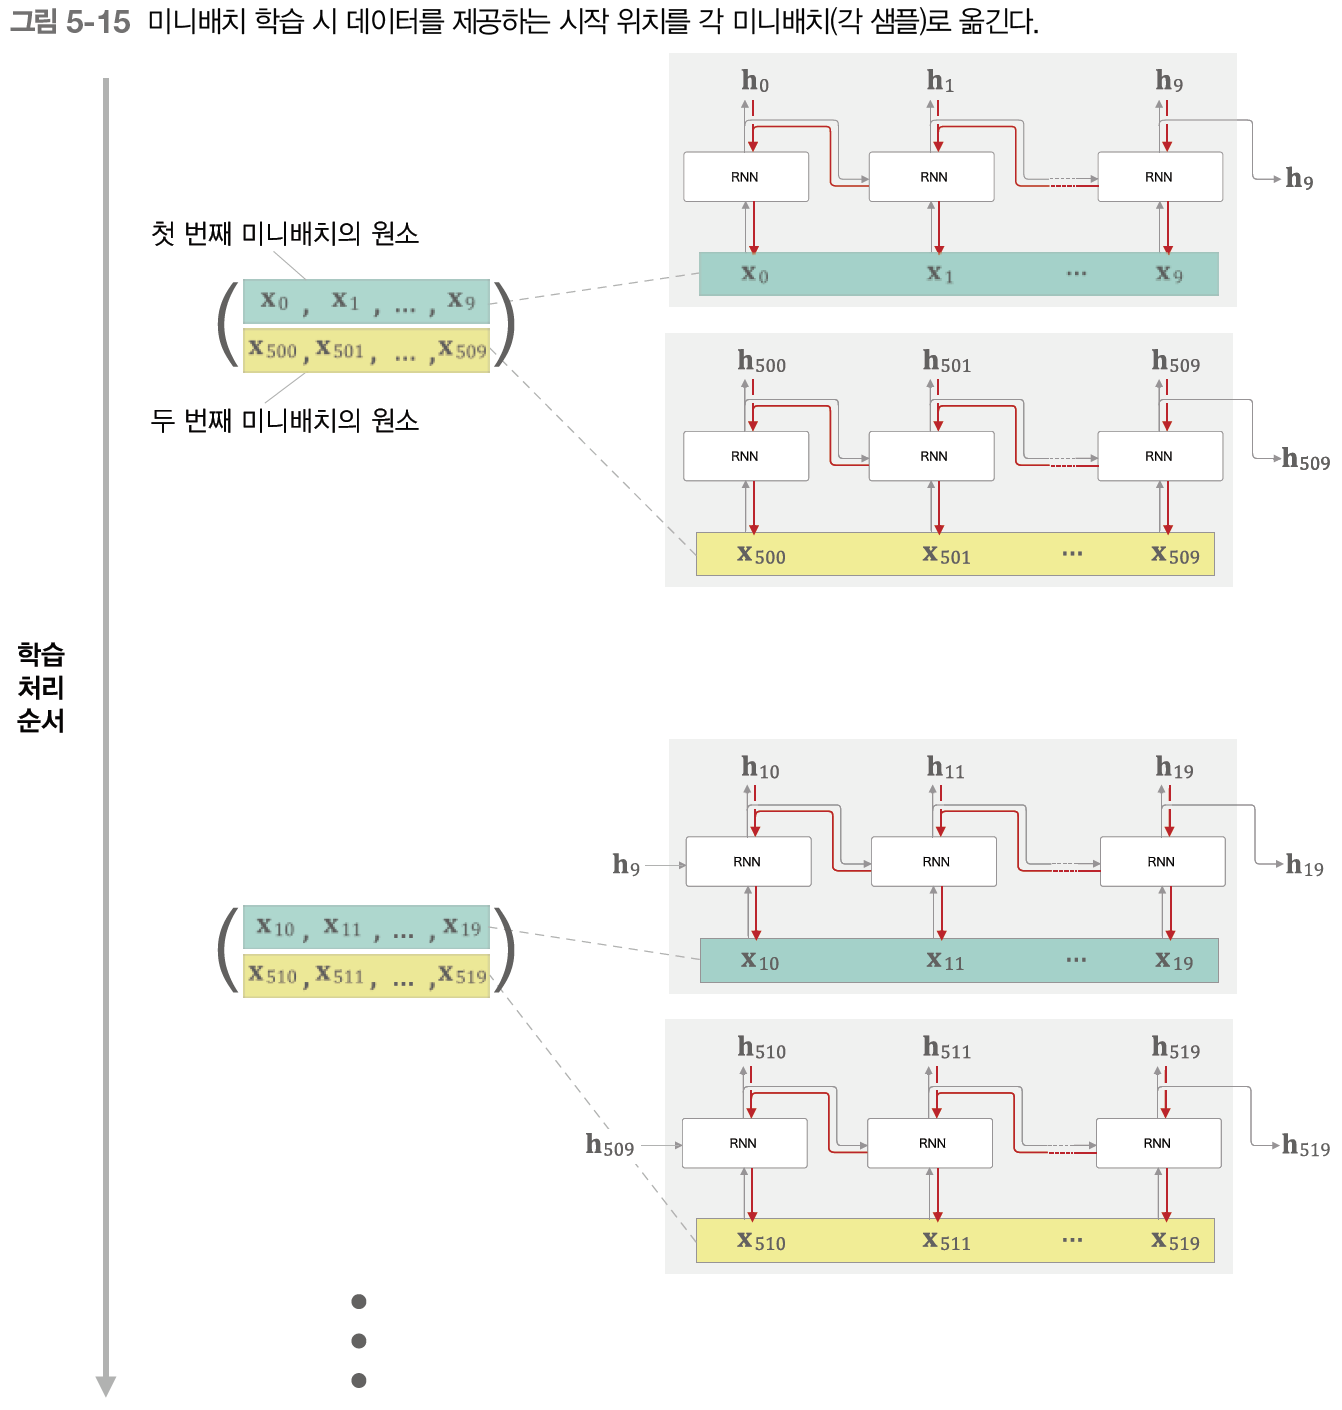

미니배치를 두 개로 구성해 학습할 때
첫 번째 미니배치 때는 처음부터 순서대로 데이터를 제공
두 번째 미니배치 때는 500번째 데이터를 시작 위치로 정하고 그 위치부터 다시 순서대로 데이터를 제공


## RNN구현

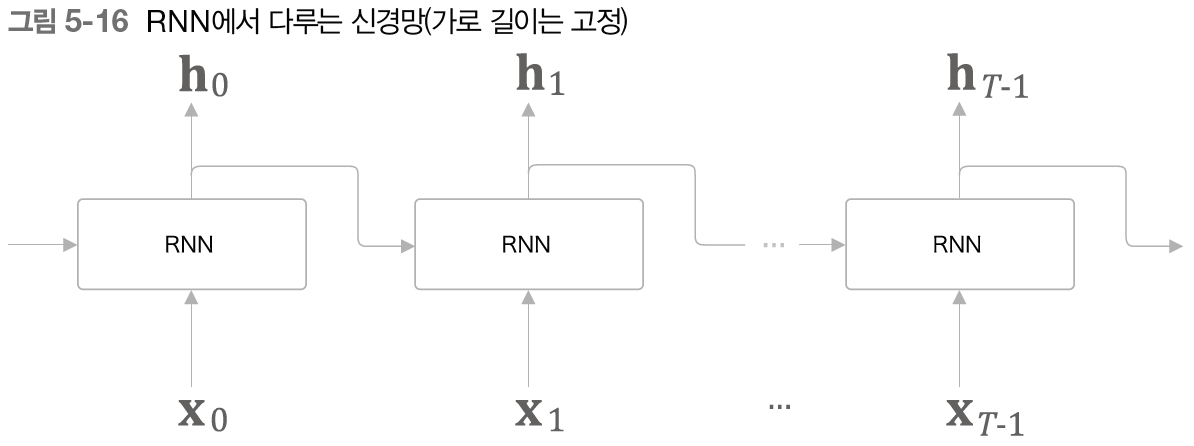
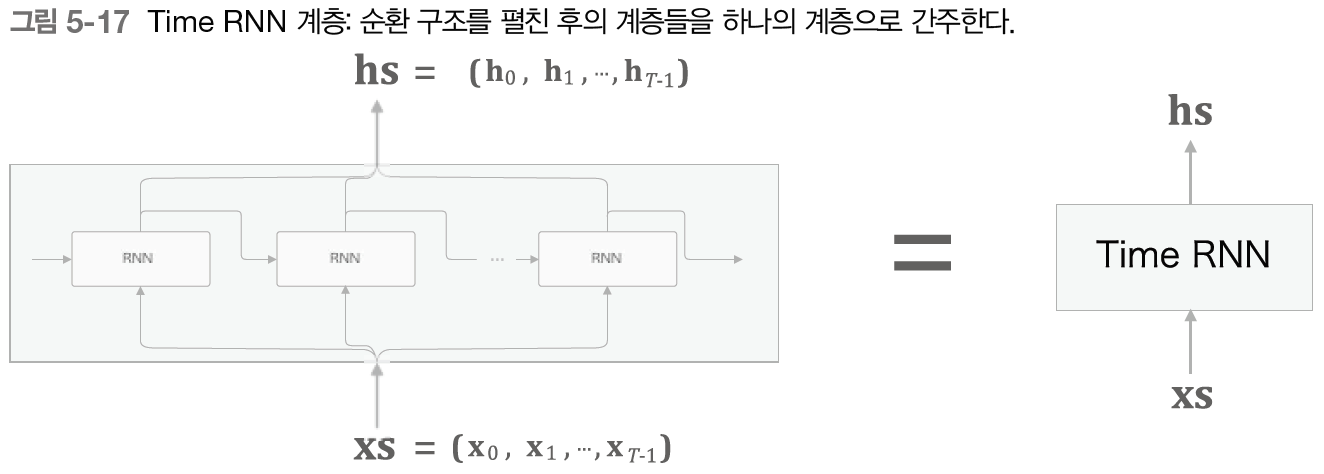

xs를 입력하면 hs를 출력하는 단일 계층
Time RNN계층 내에서 한 단계의 작업을 수행하는 계층을 'RNN계층'이라 하고
T개 단계분의 작업을 한꺼번에 처리하는 계층을 'Time RNN계층'이라 한다.

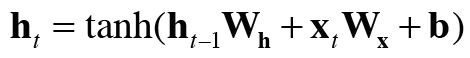
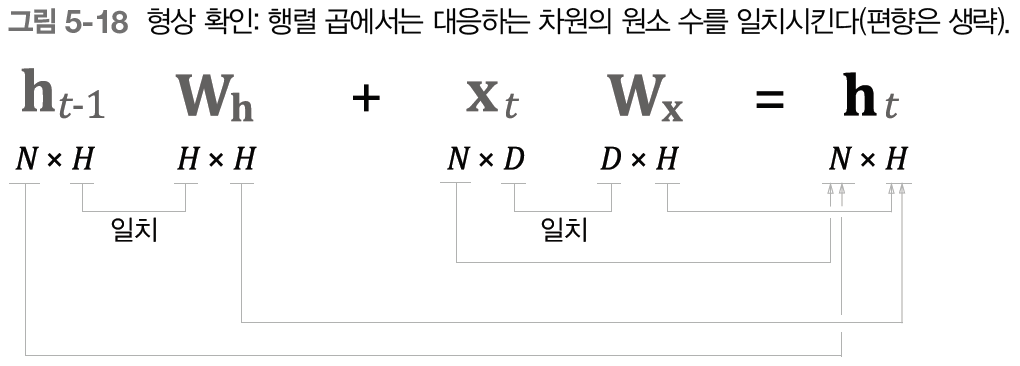

# `반드시 기억`
# `N: 미니배치 크기 D: 입력 벡터의 차원 수 H: 은닉 상태 벡터의 차원 수`

In [40]:
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid

class RNN:
    def __init__(self, Wx, Wh, b):
        """
        RNN 클래스의 초기화 메서드.
        
        :param Wx: 입력 x에 대한 가중치 행렬 (shape: (input_dim, hidden_dim))
        :param Wh: 이전 은닉 상태 h_prev에 대한 가중치 행렬 (shape: (hidden_dim, hidden_dim))
        :param b: 편향 벡터 (shape: (hidden_dim,))
        """
        self.params = [Wx, Wh, b]  # 가중치 및 편향을 params 리스트에 저장
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]  # 각 파라미터의 기울기를 저장
        self.cache = None  # 역전파 시 사용할 값을 저장할 캐시 변수

    def forward(self, x, h_prev):
        """
        순전파 계산.
        
        :param x: 현재 입력 데이터 (shape: (batch_size, input_dim))
        :param h_prev: 이전 은닉 상태 (shape: (batch_size, hidden_dim))
        :return: 다음 은닉 상태 h_next (shape: (batch_size, hidden_dim))
        
        예시 코드:
        ```python
        # RNN 매개변수 초기화
        input_dim = 4   # 입력 차원
        hidden_dim = 3  # 은닉 상태 차원

        Wx = np.random.randn(input_dim, hidden_dim)  # 입력 가중치
        Wh = np.random.randn(hidden_dim, hidden_dim)  # 은닉 가중치
        b = np.random.randn(hidden_dim)               # 편향

        rnn = RNN(Wx, Wh, b)  # RNN 객체 생성

        # 순전파 예시
        x = np.random.randn(2, input_dim)  # 임의의 입력 (batch_size=2)
        h_prev = np.random.randn(2, hidden_dim)  # 이전 은닉 상태
        h_next = rnn.forward(x, h_prev)  # 다음 은닉 상태 계산
        ```
        """
        Wx, Wh, b = self.params
        # RNN의 순전파 공식 계산식: t = h_prev * Wh + x * Wx + b
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)  # tanh 활성화 함수 적용하여 h_next 계산

        # 역전파 시 사용하기 위해 필요한 값들을 캐시에 저장
        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        """
        역전파 계산.
        
        :param dh_next: 다음 은닉 상태에 대한 기울기 (shape: (batch_size, hidden_dim))
        :return: 현재 입력 x에 대한 기울기 dx (shape: (batch_size, input_dim))
                 이전 은닉 상태 h_prev에 대한 기울기 dh_prev (shape: (batch_size, hidden_dim))
        
        예시 코드:
        ```python
        # 역전파 예시
        dh_next = np.random.randn(2, hidden_dim)  # 다음 은닉 상태에 대한 기울기
        dx, dh_prev = rnn.backward(dh_next)  # 역전파 계산
        ```
        """
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # tanh의 미분 적용
        db = np.sum(dt, axis=0)  # 편향 b에 대한 기울기 계산
        dWh = np.dot(h_prev.T, dt)  # Wh에 대한 기울기 계산
        dh_prev = np.dot(dt, Wh.T)  # 이전 은닉 상태 h_prev에 대한 기울기 계산
        dWx = np.dot(x.T, dt)  # Wx에 대한 기울기 계산
        dx = np.dot(dt, Wx.T)  # 입력 x에 대한 기울기 계산

        # 각 파라미터의 기울기를 저장
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev  # 현재 입력과 이전 은닉 상태에 대한 기울기 반환


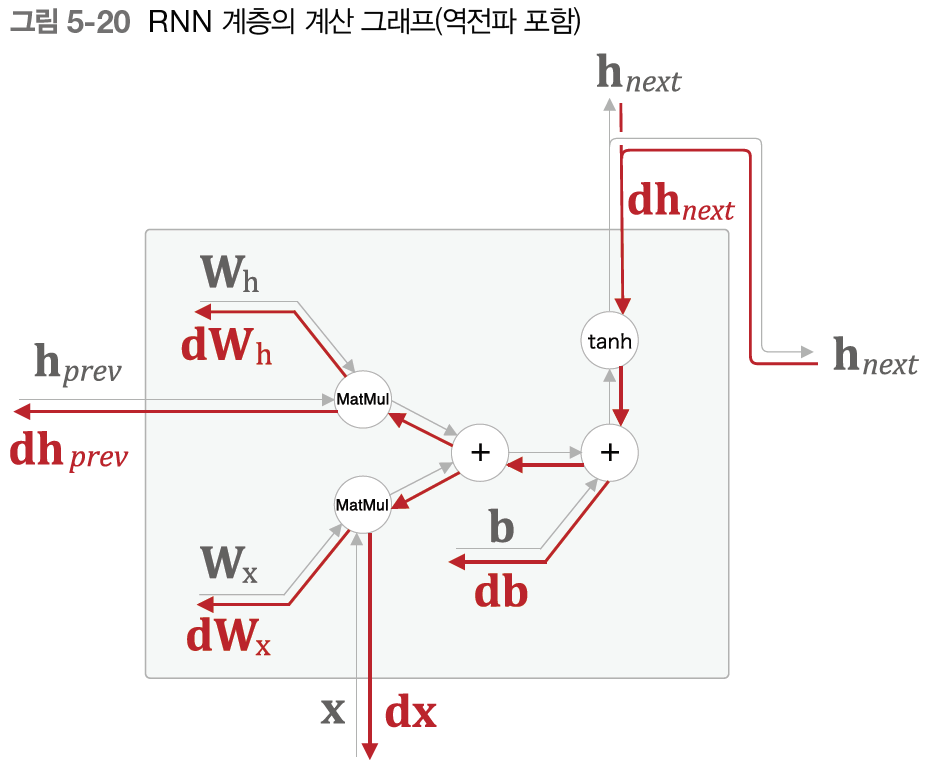

### RNN 계층의 역전파 미분 기호

- **$( dW_h $)** → $( \frac{\partial L}{\partial W_h} $): 손실 함수 $( L $)에 대한 가중치 $( W_h $)의 기울기.
- **$( dW_x $)** → $( \frac{\partial L}{\partial W_x} $): 손실 함수 $( L $)에 대한 입력 가중치 $( W_x $)의 기울기.
- **$( db $)** → $( \frac{\partial L}{\partial b} $): 손실 함수 $( L $)에 대한 편향 $( b $)의 기울기.
- **$( dh_{prev} $)** → $( \frac{\partial L}{\partial h_{prev}} $): 손실 함수 $( L $)에 대한 이전 은닉 상태 $( h_{prev} $)의 기울기.
- **$( dh_{next} $)** → $( \frac{\partial L}{\partial h_{next}} $): 손실 함수 $( L $)에 대한 다음 은닉 상태 $( h_{next} $)의 기울기.
- **$( dx $)** → $( \frac{\partial L}{\partial x} $): 손실 함수 $( L $)에 대한 입력 $( x $)의 기울기.


## Time RNN

RNN계층 T개를 연결한 신경망 Time RNN계층
RNN 계층의 은닉 상태 h를 인스턴스 변수로 유지 해 은닉 상태를 '인계'받는 용도로 이용한

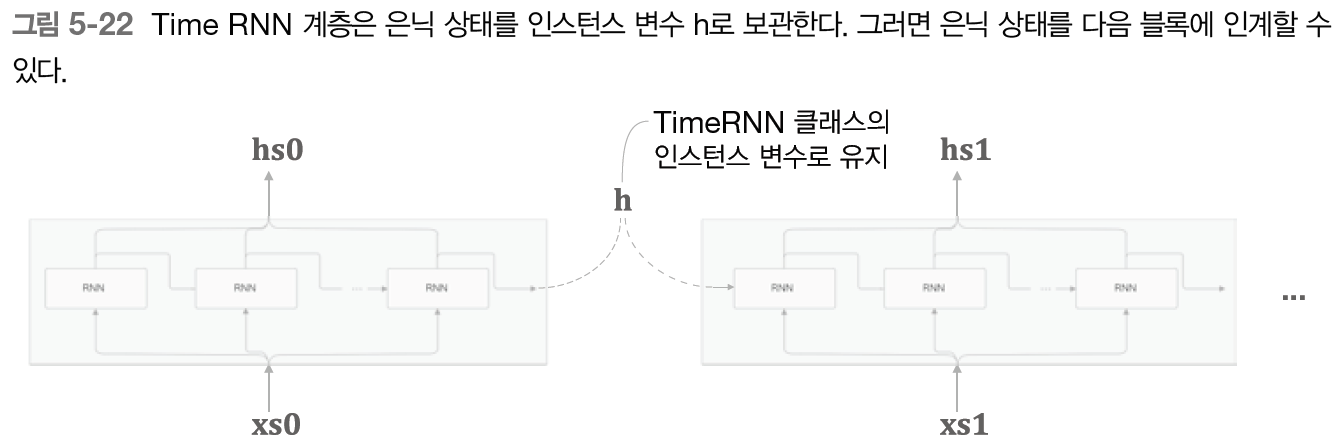

RNN계층의 은닉 상태를 Time RNN계층에서 관리하면 Time RNN사용자는 RNN계층 사이에서 은닉 상태를 '인계하는 작업'을 생각하지 않아도 된다.

In [ ]:
input_dim = 4   # 입력 차원
hidden_dim = 3  # 은닉 상태 차원

Wx = np.random.randn(input_dim, hidden_dim)  # 입력 가중치
Wh = np.random.randn(hidden_dim, hidden_dim)  # 은닉 가중치

## hidden_dim은 같은 값이여야 함


b = np.random.randn(hidden_dim)               # 편향

rnn = RNN(Wx, Wh, b)  # RNN 객체 생성


In [25]:
# 순전파 예시
x = np.random.randn(2, input_dim)  # 임의의 입력 (batch_size=2)
h_prev = np.random.randn(2, hidden_dim)  # 이전 은닉 상태



h_next = rnn.forward(x, h_prev)  # 다음 은닉 상태 계산

x,h_prev,h_next

(array([[-0.1459098 , -0.06926912, -1.51726865, -0.46313972],
        [ 0.38796275, -0.51572248, -0.72773916,  1.16268901]]),
 array([[-0.10776951, -0.03420285, -1.05349699],
        [-0.33163037,  1.15048352,  0.9976975 ]]),
 array([[-0.92321036, -0.84108806,  0.20390271],
        [ 0.47478666,  0.55497159,  0.91351213]]))

In [42]:
import numpy as np

class Test_RNN:
    def __init__(self, input_size, hidden_size):
        """
        Test_RNN 클래스의 초기화 메서드.

        :param input_size: 입력 벡터의 차원 (입력 크기)
        :param hidden_size: 은닉 상태의 차원 (은닉 크기)

        예시:
        >>> rnn = Test_RNN(input_size=3, hidden_size=4)
        >>> x_t = np.random.randn(2, 3)  # (배치 크기, 입력 크기)
        >>> h_prev = np.random.randn(2, 4)  # (배치 크기, 은닉 크기)
        >>> h_current = rnn.forward(x_t, h_prev)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        # 가중치 초기화
        self.Wx = np.random.randn(input_size, hidden_size) * 0.01  # 입력-은닉 가중치
        self.Wh = np.random.randn(hidden_size, hidden_size) * 0.01  # 은닉-은닉 가중치
        self.b = np.zeros(hidden_size)  # 편향 초기화

    def forward(self, x_t, h_prev):
        """
        RNN의 순전파 계산 메서드.

        :param x_t: 현재 입력 벡터 (배치 크기, 입력 크기)
        :param h_prev: 이전 은닉 상태 (배치 크기, 은닉 크기)
        :return: 현재 은닉 상태 (배치 크기, 은닉 크기)

        예시:
        >>> rnn = Test_RNN(input_size=3, hidden_size=4)
        >>> x_t = np.random.randn(2, 3)  # (배치 크기, 입력 크기)
        >>> h_prev = np.random.randn(2, 4)  # (배치 크기, 은닉 크기)
        >>> h_current = rnn.forward(x_t, h_prev)
        """
        h_current = np.tanh(np.dot(x_t, self.Wx) + np.dot(h_prev, self.Wh) + self.b)
        return h_current

# 예시 설정
N = 2  # 배치 크기
T = 3  # 시간 스텝 수
H = 4  # 은닉 상태 크기
input_size = 3  # 입력 크기

# 임의의 입력 데이터(xs) 및 초기 은닉 상태(h)
xs = np.random.randn(N, T, input_size)  # 입력 데이터 (2, 3, 3)
xs


array([[[ 0.63349126, -1.07404482,  0.74785891],
        [ 0.91235795,  0.49214956,  1.20521359],
        [-0.77949379,  1.10389904, -0.03402173]],

       [[-0.94786332,  0.495412  ,  0.06105917],
        [-0.0228084 ,  1.23615614,  0.28509366],
        [ 1.90072643,  0.80717558, -0.40415329]]])

1배치 (i love you):

[[ 0.63349126, -1.07404482, 0.74785891],
[ 0.91235795, 0.49214956, 1.20521359],
[-0.77949379, 1.10389904, -0.03402173]]

이 배열은 "i love you"라는 문장을 표현하는 특성(feature) 벡터들입니다. 각 내부 배열은 단어 "i", "love", "you"에 해당하는 임베딩을 나타낼 수 있습니다.

2배치 (i hate you):


[[ -0.94786332, 0.495412 , 0.06105917],
[ -0.0228084 , 1.23615614, 0.28509366],
[ 1.90072643, 0.80717558, -0.40415329]]

이 배열은 "i hate you"라는 문장을 표현하는 특성 벡터들입니다. 마찬가지로, 각 내부 배열은 단어 "i", "hate", "you"에 해당하는 임베딩을 나타낼 수 있습니다.

In [45]:
print("i love you","\n",xs[0],"\n")
print("i hate you","\n",xs[1],"\n")

i love you 
 [[ 0.63349126 -1.07404482  0.74785891]
 [ 0.91235795  0.49214956  1.20521359]
 [-0.77949379  1.10389904 -0.03402173]] 

i hate you 
 [[-0.94786332  0.495412    0.06105917]
 [-0.0228084   1.23615614  0.28509366]
 [ 1.90072643  0.80717558 -0.40415329]] 



In [46]:
print("바꾸기전 값","\n",xs,"\n")
print("바꾸기전 위치 값","\n",xs[:,1,:],"\n")
xs[:,1,:]=np.random.randn(2,3)
print("\n","바꾼 값",xs)

바꾸기전 값 
 [[[ 0.63349126 -1.07404482  0.74785891]
  [ 0.91235795  0.49214956  1.20521359]
  [-0.77949379  1.10389904 -0.03402173]]

 [[-0.94786332  0.495412    0.06105917]
  [-0.0228084   1.23615614  0.28509366]
  [ 1.90072643  0.80717558 -0.40415329]]] 

바꾸기전 위치 값 
 [[ 0.91235795  0.49214956  1.20521359]
 [-0.0228084   1.23615614  0.28509366]] 


 바꾼 값 [[[ 0.63349126 -1.07404482  0.74785891]
  [ 0.11918711  0.25264269 -0.94056685]
  [-0.77949379  1.10389904 -0.03402173]]

 [[-0.94786332  0.495412    0.06105917]
  [-1.30284951 -0.46523313 -1.4402277 ]
  [ 1.90072643  0.80717558 -0.40415329]]]


In [48]:
xs[:,1,:].shape

(2, 3)

In [47]:
h = np.zeros((N, H))  # 초기 은닉 상태를 0으로 설정 (N: 배치 크기, H: 은닉 상태 크기)

# RNN 레이어 생성
rnn = Test_RNN(input_size, H)  # 입력 크기와 은닉 상태 크기를 이용해 RNN 레이어 초기화
hs = np.empty((N, T, H), dtype='f')  # 각 시간 스텝에서의 은닉 상태 출력을 저장할 배열 (N, T, H)

print(hs, hs.shape, "\n")  # 초기 은닉 상태 배열과 그 형태 출력

# 각 시간 스텝에 대해 순차적으로 RNN을 실행
for t in range(T):
    h = rnn.forward(xs[:, t, :], h)  # 현재 스텝의 입력과 이전 은닉 상태로부터 현재 은닉 상태를 계산
    print(h.shape)  # 현재 은닉 상태의 형태 출력
    hs[:, t, :] = h  # 출력 은닉 상태 저장: 배치 단위로 t 시점의 히든 값을 hs 배열에 저장
    print(hs, "\n")  # 현재까지의 은닉 상태 배열을 출력


[[[-3.2386500e+35 -9.8396909e-01 -9.8652716e-05  1.0100693e+00]
  [ 1.1153838e+10 -1.2453992e+00  6.5159993e-28 -9.6863157e-01]
  [-2.7253662e-05  9.4795722e-01  1.5170941e+37  1.0701197e+00]]

 [[ 2.8760141e+02 -9.5693296e-01 -3.3833718e-30  9.4560868e-01]
  [-1.4058243e-09  1.0410743e+00 -1.2281927e-16  1.1553411e+00]
  [ 4.4232952e-37 -9.4772869e-01  1.7160440e-08  1.0138520e+00]]] (2, 3, 4) 

(2, 4)
[[[ 6.1880159e-03  2.4809325e-02 -3.7605905e-03 -6.5963767e-03]
  [ 1.1153838e+10 -1.2453992e+00  6.5159993e-28 -9.6863157e-01]
  [-2.7253662e-05  9.4795722e-01  1.5170941e+37  1.0701197e+00]]

 [[-1.2274095e-02 -1.1152292e-02 -5.0136293e-03  7.1330699e-03]
  [-1.4058243e-09  1.0410743e+00 -1.2281927e-16  1.1553411e+00]
  [ 4.4232952e-37 -9.4772869e-01  1.7160440e-08  1.0138520e+00]]] 

(2, 4)
[[[ 6.1880159e-03  2.4809325e-02 -3.7605905e-03 -6.5963767e-03]
  [-1.4979743e-03 -1.5848728e-02  7.7057709e-03  3.4394590e-03]
  [-2.7253662e-05  9.4795722e-01  1.5170941e+37  1.0701197e+00]]

 [

In [36]:
# 결과 출력
print("출력 은닉 상태 (hs):")
print(hs)

출력 은닉 상태 (hs):
[[[ 9.2807440e-03 -2.6141088e-03  2.8669918e-02  8.1412466e-03]
  [-1.2297586e-02 -3.7686162e-02  2.7350122e-02 -1.0379323e-02]
  [ 2.2047766e-02  1.8516926e-03  5.5098675e-02  1.9622117e-02]]

 [[ 4.7116661e-03 -1.0813211e-02  2.8634692e-02  3.9735553e-03]
  [-4.0581557e-03  1.4447826e-02 -3.5348181e-02 -3.8703294e-03]
  [ 9.4512291e-04 -2.5206234e-03  3.7734406e-03 -1.2878269e-05]]]


In [ ]:
import numpy as np

class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        """
        TimeRNN 클래스 초기화 함수.
        
        :param Wx: 입력에 대한 가중치 (input weight)
        :param Wh: 은닉 상태에 대한 가중치 (hidden weight)
        :param b: 편향 (bias)
        :param stateful: 은닉 상태를 유지할지 여부를 결정하는 플래그 (default=False)

        예시:
        >>> Wx = np.random.randn(3, 4)
        >>> Wh = np.random.randn(4, 4)
        >>> b = np.zeros(4)
        >>> rnn = TimeRNN(Wx, Wh, b, stateful=True)
        """
        # 가중치 및 편향을 params 리스트에 저장
        self.params = [Wx, Wh, b]
        # 각 파라미터의 기울기를 저장할 배열
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # RNN 레이어들을 저장할 리스트

        # 은닉 상태와 그에 대한 기울기 저장
        self.h, self.dh = None, None
        self.stateful = stateful  # stateful 여부 플래그

    def forward(self, xs):
        """
        순전파 함수. 여러 시간 스텝을 가진 입력 xs에 대해 순차적으로 RNN을 실행.
        
        :param xs: 입력 데이터 (배치 크기, 시간 스텝, 입력 차원) 형태
        :return: 모든 시간 스텝의 은닉 상태 출력 (배치 크기, 시간 스텝, 은닉 차원)

        예시:
        >>> xs = np.random.randn(2, 3, 3)  # (배치 크기, 시간 스텝, 입력 차원)
        >>> h = rnn.forward(xs)
        """
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N: 배치 크기, T: 시간 스텝, D: 입력 차원
        D, H = Wx.shape  # H: 은닉 상태 차원 (Wx의 두 번째 차원)

        self.layers = []  # 시간 스텝마다의 RNN 레이어를 저장할 리스트
        hs = np.empty((N, T, H), dtype='f')  # 은닉 상태 출력을 저장할 배열

        # stateful 모드가 아니거나 은닉 상태가 None이면, 은닉 상태 초기화
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')  # 이전 상태에서 받은 값이 존재하는지 체크

        # 각 시간 스텝에 대해 순차적으로 RNN을 실행
        for t in range(T):
            layer = RNN(*self.params)  # RNN 레이어 생성
            self.h = layer.forward(xs[:, t, :], self.h)  # 현재 스텝의 입력과 은닉 상태로 계산
            hs[:, t, :] = self.h  # 출력 은닉 상태 저장
            self.layers.append(layer)  # 레이어를 리스트에 저장
            # 각 시점 x_t0,,,1,,,,n의 값들을 순서대로 넣어줘서 ht를 계산하고 이를 다시 hs에 모아줌
            
        return hs  # 모든 시간 스텝의 은닉 상태 출력

    def backward(self, dhs):
        """
        역전파 함수. 은닉 상태 기울기 dhs에 대해 역전파를 수행.
        
        :param dhs: 출력 은닉 상태의 기울기 (배치 크기, 시간 스텝, 은닉 상태 차원) 형태
        :return: 입력에 대한 기울기 (배치 크기, 시간 스텝, 입력 차원) 형태

        예시:
        >>> dhs = np.random.randn(2, 3, 4)  # (배치 크기, 시간 스텝, 은닉 차원)
        >>> dxs = rnn.backward(dhs)
        """
        Wx, Wh, b = self.params
        N, T, H = dhs.shape  # N: 배치 크기, T: 시간 스텝, H: 은닉 상태 차원
        D, H = Wx.shape  # D: 입력 차원

        dxs = np.empty((N, T, D), dtype='f')  # 입력에 대한 기울기를 저장할 배열
        dh = 0  # 다음 스텝으로 전달될 은닉 상태 기울기
        grads = [0, 0, 0]  # Wx, Wh, b에 대한 기울기를 저장할 리스트

        # 시간 스텝을 역순으로 역전파 수행
        for t in reversed(range(T)):
            layer = self.layers[t]  # 각 스텝의 레이어 가져오기
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 현재 스텝의 기울기와 다음 스텝의 기울기를 더해 역전파
            dxs[:, t, :] = dx  # 입력 기울기 저장

            # 각 가중치 기울기 누적
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        # 최종적으로 누적된 가중치 기울기를 저장
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh  # 은닉 상태의 마지막 기울기 저장

        return dxs  # 입력 기울기 반환

    def set_state(self, h):
        """
        은닉 상태 설정 함수. 다음 순전파 시 이 은닉 상태를 사용.
        
        :param h: 은닉 상태 값

        예시:
        >>> rnn.set_state(np.random.randn(2, 4))  # (배치 크기, 은닉 차원)
        """
        self.h = h

    def reset_state(self):
        """
        은닉 상태 초기화 함수. 은닉 상태를 None으로 설정해 다음 순전파 시 초기화되도록 함.

        예시:
        >>> rnn.reset_state()  # 은닉 상태 초기화
        """
        self.h = None


In [52]:
import numpy as np

# TimeRNN 클래스와 RNN 클래스는 이미 제공된 것과 동일하게 정의되어 있다고 가정합니다.

# 예시 데이터를 위한 설정
N, T, D, H = 3, 5, 4, 6  # N: 배치 크기, T: 시간 스텝, D: 입력 차원, H: 은닉 상태 차원

# 무작위 입력 데이터 (N: 배치 크기, T: 시간 스텝, D: 입력 차원)
xs = np.random.randn(N, T, D).astype('f')

# RNN의 가중치 및 편향 설정 (무작위 초기화)
Wx = np.random.randn(D, H).astype('f')  # 입력에 대한 가중치
Wh = np.random.randn(H, H).astype('f')  # 은닉 상태에 대한 가중치
b = np.random.randn(H).astype('f')      # 편향

# RNN 모델 초기화
time_rnn = TimeRNN(Wx, Wh, b)

# 순전파 수행
hs = time_rnn.forward(xs)
print("순전파 출력 (hs):")
print(hs.shape)



순전파 출력 (hs):
(3, 5, 6)


In [53]:
xs.shape,xs[0]

((3, 5, 4),
 array([[-5.6731725e-01, -7.2571456e-02,  4.4382912e-01,  9.4746786e-01],
        [ 1.3999431e-01,  1.5027999e-03,  2.0080426e+00,  7.7157813e-01],
        [ 7.8849655e-01,  2.8216887e-01,  1.0494882e+00,  9.5387787e-01],
        [-2.0039283e-01,  2.1021442e+00, -6.3682467e-02,  8.8665150e-02],
        [-3.1556156e-01, -1.3072890e+00,  2.5553247e-01, -8.9739072e-01]],
       dtype=float32))

In [54]:
Wx.shape

(4, 6)

In [55]:
hs.shape,hs[0]

((3, 5, 6),
 array([[ 0.76726246,  0.01917841,  0.95901686, -0.942322  , -0.96337897,
         -0.5078209 ],
        [-0.4368955 , -0.6823641 ,  0.9841145 ,  0.9375344 , -0.99855316,
          0.8601147 ],
        [-0.68510526,  0.9999997 ,  0.45959228, -0.4148001 , -0.96839255,
          0.3256413 ],
        [ 0.15773436,  0.9717465 ,  0.08355208, -0.9722602 ,  0.999804  ,
          0.7841599 ],
        [ 0.99976015, -0.99282205, -0.6214928 ,  0.85322744, -0.9999671 ,
          0.7155219 ]], dtype=float32))

In [56]:
Wh.shape

(6, 6)

In [57]:
# 역전파 수행을 위한 출력 기울기 (dhs: 순전파 출력의 기울기)
dhs = np.random.randn(N, T, H).astype('f')

# 역전파 수행
dxs = time_rnn.backward(dhs)
print("\n역전파 입력 기울기 (dxs):")
print(dxs)

# 최종 기울기 출력
print("\nWx에 대한 기울기 (dWx):")
print(time_rnn.grads[0].shape)
print("\nWh에 대한 기울기 (dWh):")
print(time_rnn.grads[1].shape)
print("\nb에 대한 기울기 (db):")
print(time_rnn.grads[2].shape)


역전파 입력 기울기 (dxs):
[[[-7.811864   -7.9908495   1.7678905  -6.2714925 ]
  [ 3.650111    8.001089   -0.0586133   1.5860314 ]
  [ 2.2700002  -6.7687078  -1.2839882   3.729332  ]
  [ 1.3637604   0.5636675  -1.7419      5.0596576 ]
  [ 0.35396582 -0.2497389  -0.43269306  1.527973  ]]

 [[ 0.06902244  0.11672026 -1.0801233   0.5290833 ]
  [ 1.1298678  -4.5248523   1.7804815   0.02071054]
  [-0.5128268   0.8642799  -1.040526    0.6586732 ]
  [ 0.40889016  2.2126493   2.100812   -0.32278854]
  [ 1.0863616   0.3584997   0.7940594   0.89912677]]

 [[-0.5031908   8.07636    -2.0036614   0.66144615]
  [ 1.3511869   1.1982437   5.975706   -2.3968122 ]
  [ 1.2205355  -0.17149583 -0.38934094  1.0112227 ]
  [ 4.4195232  -5.6918974   5.435708   -0.5727992 ]
  [ 1.8575362   1.20197     1.0705861   0.3468194 ]]]

Wx에 대한 기울기 (dWx):
(4, 6)

Wh에 대한 기울기 (dWh):
(6, 6)

b에 대한 기울기 (db):
(6,)


## RNNLM의 전체 그림
RNNLM(RNN Language Model): RNN을 사용한 언어 모델

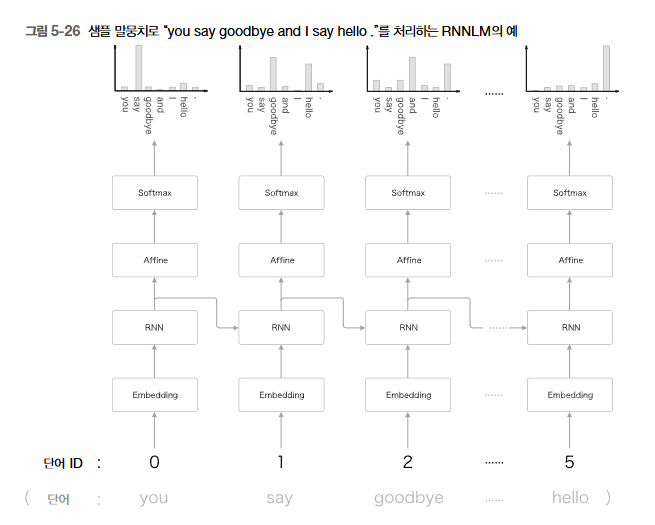

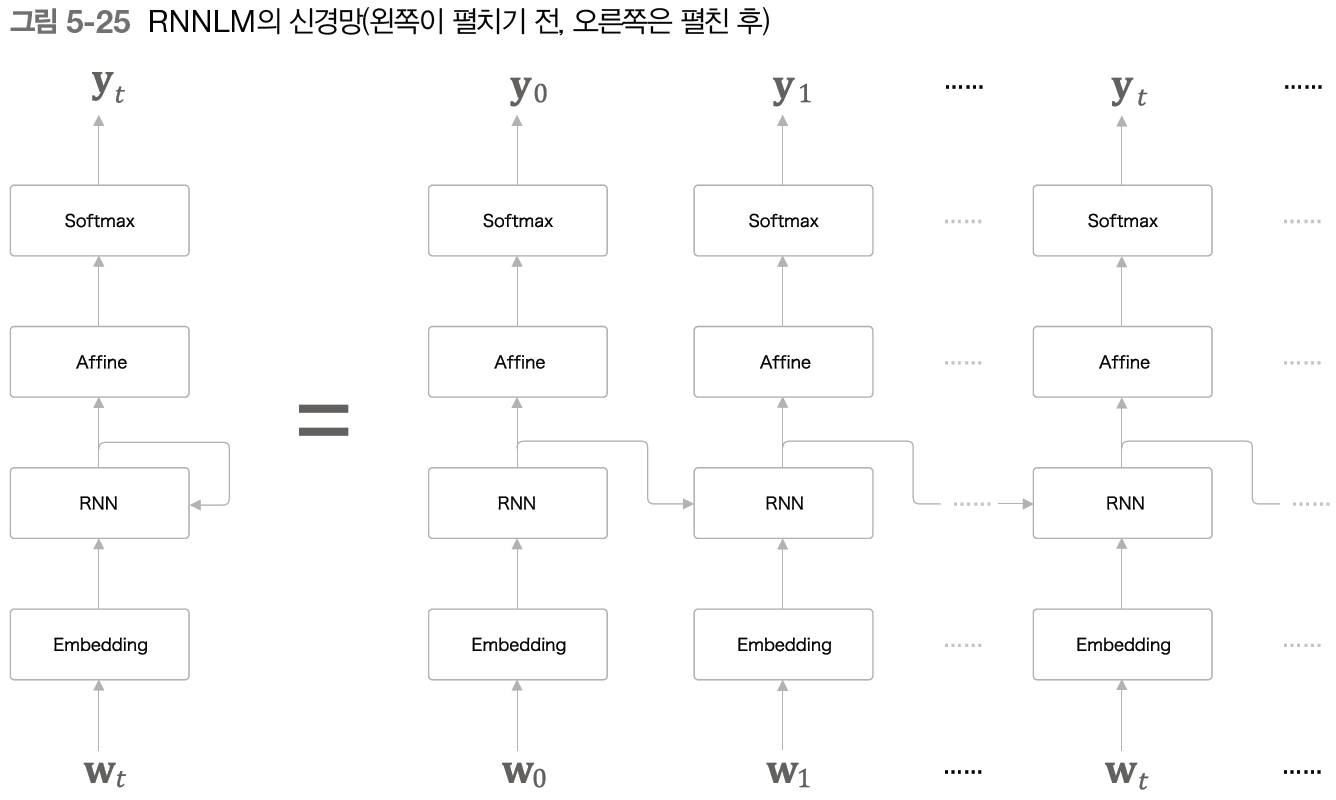

Embedding: 단어 ID를 단어의 분산 표현(단어 벡터)으로 변환
RNN계층: 은닉 상태를 다음 층으로(위쪽으로) 출력함과 동시에 다음 시각의 RNN 계층으로(오른쪽으로) 출력한다.
RNN계층이 위로 출력한 은닉 상태는 Affine 계층을 거쳐 Softmax계층으로 전해진다.

RNNLM은 지금까지 입력된 단어를 '기억'하고 그것을 바탕으로 다음에 출현할 단어를 예측한다. RNN계층이 과거에서 현재로 데이터를 계속 흘려보내줌으로써 과거의 정보를 인코딩해 저장(기억) 할 수 있다.


## Time 계층 구현
시계열 데이터를 한꺼번에 처리하는 계층
Time Embedding, Time Affine...
Time 계층은 간단하게 구현할 수 있다.
예를 들어 Time Affine계층은 Affine계층을 T개 준비해서 각 시각의 데이터를 개별적으로 처리하면 된다.

시계열 버전의 Softmax계층을 구현할 때는 손실 오차를 구하는 Cross Entropy Error 계층도 함께 구현한다.

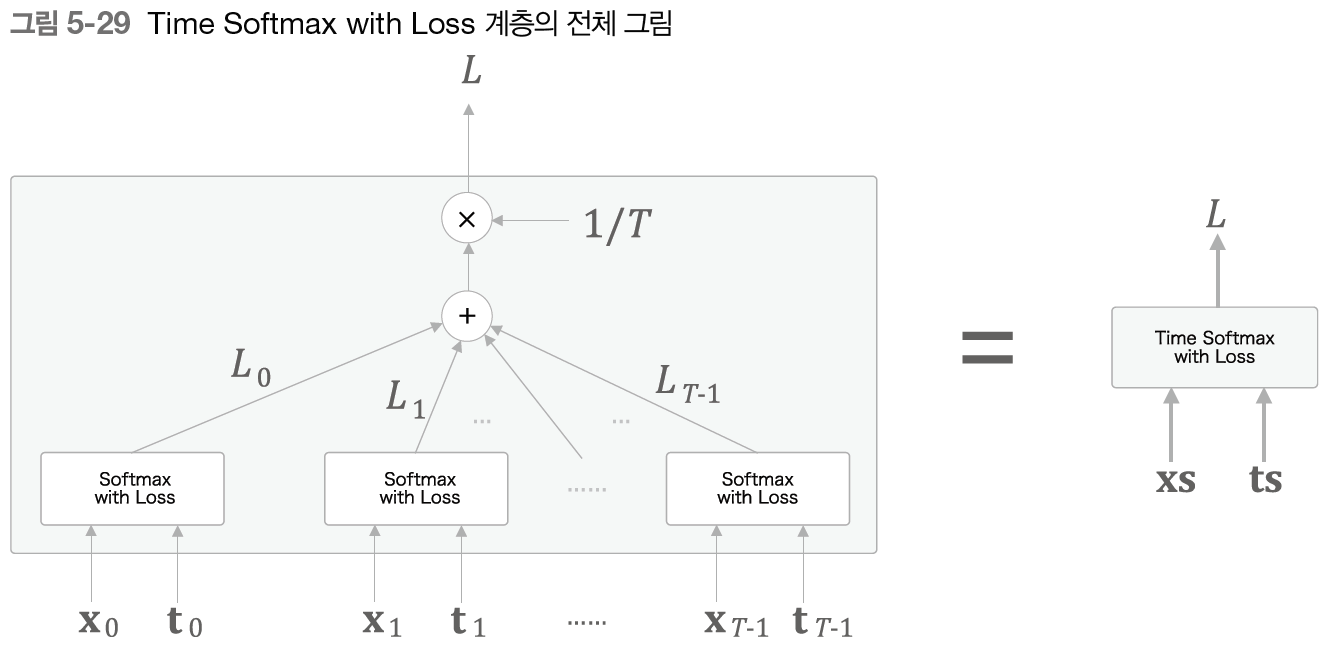

x0, x1,... : 아래층에서부터 전해지는 점수(확률로 정규화되기 전의 값)
t0, t1,... : 정답 레이블
T개의 Softmax with Loss 계층 각각이 손실을 산출하고 그 손실들을 합산해 평균한 값이 최종 손실이 된다.

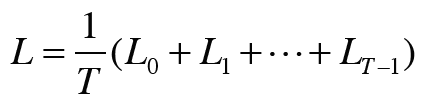

Time Softmax with Loss 계층도 시계열에 대한 평균을 구하는 것으로 데이터 1개당 평균 손실을 구해 최종 출력으로 내보낸다.

## RNNLM 학습과 평가
# RNNLM 구현

In [58]:
class Embedding:
    def __init__(self, W):
        """
        Embedding 클래스 초기화 함수.

        W: 임베딩 가중치 (weights)

        예시:
        >>> W = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])  # 가중치 초기화
        >>> embedding = Embedding(W)
        """
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        """
        순전파 함수. 주어진 인덱스를 이용해 임베딩을 가져옴.

        idx: 입력 인덱스

        예시:
        >>> idx = np.array([0, 2])  # 인덱스 입력
        >>> out = embedding.forward(idx)
        >>> print(out)  # W의 0번 및 2번 인덱스의 임베딩 출력
        [[0.1 0.2]
         [0.5 0.6]]
        """
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        """
        역전파 함수. 임베딩의 기울기를 계산.

        dout: 다음 레이어로 전달될 기울기

        예시:
        >>> dout = np.array([[1.0, 0.0], [0.0, 1.0]])  # 기울기 입력
        >>> embedding.backward(dout)  # 기울기 역전파
        >>> print(embedding.grads[0])  # W의 기울기 출력
        [[1. 0.]
         [0. 0.]
         [0. 1.]]
        """
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None


In [59]:
class TimeEmbedding:
    def __init__(self, W):
        """
        TimeEmbedding 클래스 초기화 메서드.

        :param W: 임베딩 가중치 행렬 (V x D)

        예시:
        >>> W = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])  # 임베딩 가중치 행렬 초기화
        >>> time_embedding = TimeEmbedding(W)  # TimeEmbedding 객체 생성
        """
        self.params = [W]  # 가중치 행렬을 params 리스트에 저장
        self.grads = [np.zeros_like(W)]  # 가중치의 그래디언트를 0으로 초기화하여 grads 리스트에 저장
        self.layers = None  # 각 시간 스텝의 Embedding 레이어를 저장할 변수 초기화
        self.W = W  # 임베딩 가중치 저장

    def forward(self, xs):
        """
        순전파 메서드 (forward propagation).

        :param xs: 입력 데이터 (N x T) 형태, N: 배치 크기, T: 시간 스텝 수
        :return: 임베딩된 출력 (N x T x D)

        예시:
        >>> xs = np.array([[0, 2], [1, 0]])  # 입력 데이터 (2, 2)
        >>> out = time_embedding.forward(xs)  # 순전파 계산
        >>> print(out)  # 임베딩된 출력 확인
        [[0.1 0.2]
         [0.5 0.6]]
        [[0.3 0.4]
         [0.1 0.2]]
        """
        N, T = xs.shape  # N: 배치 크기, T: 시간 스텝 수
        V, D = self.W.shape  # V: 어휘 크기, D: 임베딩 차원

        out = np.empty((N, T, D), dtype='f')  # 출력 배열 초기화
        self.layers = []  # 각 시간 스텝의 Embedding 레이어를 저장할 리스트 초기화

        # 각 시간 스텝에 대해 Embedding 레이어 순전파
        for t in range(T):
            layer = Embedding(self.W)  # 현재 시간 스텝의 Embedding 레이어 생성
            out[:, t, :] = layer.forward(xs[:, t])  # 순전파 계산하여 출력에 저장
            self.layers.append(layer)  # 생성한 레이어를 리스트에 추가

        return out  # 최종 출력 반환

    def backward(self, dout):
        """
        역전파 메서드 (backward propagation).

        :param dout: 상위 레이어에서 전해받은 손실의 그래디언트 (N x T x D)
        :return: None

        예시:
        >>> dout = np.array([[[1.0, 0.0], [0.0, 1.0]], [[0.0, 1.0], [1.0, 0.0]]])  # 손실의 그래디언트
        >>> time_embedding.backward(dout)  # 역전파 수행
        >>> print(time_embedding.grads[0])  # 가중치의 그래디언트 확인
        [[1. 0.]
         [0. 1.]
         [1. 0.]]
        """
        N, T, D = dout.shape  # dout의 형태에서 N, T, D 추출

        grad = 0  # 가중치의 그래디언트 초기화
        # 각 시간 스텝에 대해 역전파 수행
        for t in range(T):
            layer = self.layers[t]  # 현재 시간 스텝의 레이어 선택
            layer.backward(dout[:, t, :])  # 현재 레이어에 대해 역전파 수행
            grad += layer.grads[0]  # 현재 레이어의 그래디언트를 누적

        self.grads[0][...] = grad  # 누적된 그래디언트를 grads 리스트에 저장
        return None  # 반환값 없음


In [60]:
import numpy as np

# 예시 데이터의 매개변수
N = 4  # 배치 크기
T = 5  # 시간 단계 수
V = 10  # 어휘 크기 (고유 단어의 수)
D = 3   # 임베딩 차원

# 입력 데이터에 대한 무작위 인덱스 생성 (0부터 V-1까지)
xs = np.random.randint(0, V, size=(N, T)) # 0-V 사이 (N,T) 생성

print(xs)

# 무작위 임베딩 가중치 행렬 생성
W = np.random.rand(V, D)  # 임베딩 가중치에 대한 무작위 값

# TimeEmbedding 인스턴스 생성
time_embedding = TimeEmbedding(W)

# 순전파 수행
output = time_embedding.forward(xs)

# 예시 입력 및 출력 출력
print("입력 (xs):")
print(xs)



[[1 5 8 1 1]
 [3 6 5 9 6]
 [9 0 7 2 3]
 [3 3 9 4 2]]
입력 (xs):
[[1 5 8 1 1]
 [3 6 5 9 6]
 [9 0 7 2 3]
 [3 3 9 4 2]]


In [61]:
xs[:,1]

array([5, 6, 0, 3])

In [64]:
print("\n임베딩 가중치 행렬 (W):")
print(time_embedding.W)



임베딩 가중치 행렬 (W):
[[0.62573702 0.52204755 0.91911121]
 [0.1317792  0.38547699 0.99666559]
 [0.6389502  0.62477456 0.27045045]
 [0.48811902 0.65602603 0.70039075]
 [0.31913666 0.11760748 0.20549983]
 [0.63319706 0.98387735 0.66045297]
 [0.69307022 0.44679293 0.32813168]
 [0.92831838 0.89264301 0.4665494 ]
 [0.83745547 0.82743187 0.68201546]
 [0.31245944 0.69362609 0.87303297]]


In [65]:
print(time_embedding.W[xs[:,1]])

[[0.63319706 0.98387735 0.66045297]
 [0.69307022 0.44679293 0.32813168]
 [0.62573702 0.52204755 0.91911121]
 [0.48811902 0.65602603 0.70039075]]


In [63]:
print("\n출력 (임베딩된 표현):")
print(output)


출력 (임베딩된 표현):
[[[0.1317792  0.38547698 0.9966656 ]
  [0.63319707 0.98387736 0.66045296]
  [0.83745545 0.82743186 0.6820155 ]
  [0.1317792  0.38547698 0.9966656 ]
  [0.1317792  0.38547698 0.9966656 ]]

 [[0.48811904 0.656026   0.70039076]
  [0.69307023 0.44679293 0.32813168]
  [0.63319707 0.98387736 0.66045296]
  [0.31245944 0.6936261  0.873033  ]
  [0.69307023 0.44679293 0.32813168]]

 [[0.31245944 0.6936261  0.873033  ]
  [0.625737   0.5220475  0.9191112 ]
  [0.9283184  0.89264303 0.4665494 ]
  [0.6389502  0.6247746  0.27045044]
  [0.48811904 0.656026   0.70039076]]

 [[0.48811904 0.656026   0.70039076]
  [0.48811904 0.656026   0.70039076]
  [0.31245944 0.6936261  0.873033  ]
  [0.31913665 0.11760747 0.20549983]
  [0.6389502  0.6247746  0.27045044]]]


In [66]:
class TimeAffine:
    """
    시계열 데이터를 처리하는 Affine 계층 (fully-connected layer)

    Parameters
    ----------
    W : numpy.ndarray
        가중치 행렬 (D, M)
    b : numpy.ndarray
        편향 벡터 (M,)

    Attributes
    ----------
    params : list of numpy.ndarray
        가중치와 편향을 저장하는 리스트
    grads : list of numpy.ndarray
        가중치와 편향의 기울기를 저장하는 리스트
    x : numpy.ndarray
        순전파 시 입력 데이터를 저장하는 변수
    """

    def __init__(self, W, b):
        """
        TimeAffine 초기화 메서드.

        Parameters
        ----------
        W : numpy.ndarray
            가중치 행렬 (D, M)
        b : numpy.ndarray
            편향 벡터 (M,)

        예시:
        >>> W = np.random.randn(3, 4)
        >>> b = np.zeros(4)
        >>> layer = TimeAffine(W, b)
        """
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        """
        순전파 수행.

        Parameters
        ----------
        x : numpy.ndarray
            입력 데이터 (N, T, D) (배치 크기 N, 시계열 길이 T, 입력 차원 D)

        Returns
        -------
        numpy.ndarray
            출력 데이터 (N, T, M) (배치 크기 N, 시계열 길이 T, 출력 차원 M)

        예시:
        >>> x = np.random.randn(2, 3, 3)  # 입력 데이터 (배치 크기 2, 시계열 길이 3, 입력 차원 3)
        >>> out = layer.forward(x)  # 순전파 수행
        >>> print(out.shape)  # 출력 데이터 크기 출력 (2, 3, 4)
        """
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N * T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        """
        역전파 수행.

        Parameters
        ----------
        dout : numpy.ndarray
            출력 기울기 (N, T, M)

        Returns
        -------
        numpy.ndarray
            입력 기울기 (N, T, D)

        예시:
        >>> dout = np.random.randn(2, 3, 4)  # 출력 기울기
        >>> dx = layer.backward(dout)  # 역전파 수행
        >>> print(dx.shape)  # 입력 기울기 크기 출력 (2, 3, 3)
        """
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N * T, -1)
        rx = x.reshape(N * T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


In [67]:
class TimeSoftmaxWithLoss:
    """
    시계열 데이터를 처리하는 Softmax 계층과 손실 함수 (cross-entropy loss).

    Attributes
    ----------
    params : list
        가중치가 없는 계층이므로 빈 리스트
    grads : list
        기울기 계산이 없으므로 빈 리스트
    cache : tuple
        순전파 시 저장된 변수들을 역전파에서 사용하기 위해 저장
    ignore_label : int
        무시할 레이블 값. 이 값에 해당하는 레이블은 손실 계산에서 제외
    
    Methods
    -------
    forward(xs, ts)
        순전파 수행. 입력 데이터와 정답 레이블을 받아서 손실을 계산.
    backward(dout=1)
        역전파 수행. 기울기 계산.
    """

    def __init__(self):
        """
        TimeSoftmaxWithLoss 초기화 메서드.

        예시:
        >>> layer = TimeSoftmaxWithLoss()
        """
        self.params, self.grads = []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        """
        순전파 수행.

        Parameters
        ----------
        xs : numpy.ndarray
            입력 데이터 (N, T, V) (배치 크기 N, 시계열 길이 T, 어휘 크기 V)
        ts : numpy.ndarray
            정답 레이블 (N, T) 또는 (N, T, V) (정답 레이블이 원핫 벡터인 경우)

        Returns
        -------
        float
            손실 값

        예시:
        >>> xs = np.random.randn(2, 3, 5)  # 입력 데이터 (배치 크기 2, 시계열 길이 3, 어휘 크기 5)
        >>> ts = np.array([[1, 2, 3], [0, 1, 2]])  # 정답 레이블
        >>> loss = layer.forward(xs, ts)  # 순전파 수행
        >>> print(loss)  # 손실 값 출력
        """
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        """
        역전파 수행.

        Parameters
        ----------
        dout : float
            상위 계층에서 전해지는 기울기. 기본값은 1.

        Returns
        -------
        numpy.ndarray
            입력 데이터에 대한 기울기 (N, T, V)

        예시:
        >>> dout = 1  # 기울기
        >>> dx = layer.backward(dout)  # 역전파 수행
        >>> print(dx.shape)  # 입력 기울기 크기 출력 (2, 3, 5)
        """
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


In [68]:

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        """
        SimpleRnnlm 클래스 초기화 메서드.

        :param vocab_size: 어휘 크기
        :param wordvec_size: 단어 벡터 크기
        :param hidden_size: 은닉 상태 크기

        예시:
        >>> vocab_size = 10  # 어휘 크기
        >>> wordvec_size = 5  # 단어 벡터 크기
        >>> hidden_size = 4  # 은닉 상태 크기
        >>> model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)  # 모델 초기화
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn  # 가우시안 표준정규분포로 가중치를 초기화하기 위해 np.random.randn 사용

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')  
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')  
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')  
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),             
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),  
            TimeAffine(affine_W, affine_b)      
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]  

        # 모든 계층의 가중치와 기울기를 리스트에 저장
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params  
            self.grads += layer.grads    

    def forward(self, xs, ts):
        """
        순전파 수행.

        :param xs: 입력 데이터 (단어 ID)
        :param ts: 정답 레이블 (단어 ID)
        :return: 손실 값

        예시:
        >>> xs = np.array([[1, 2], [3, 4]])  # 입력 데이터 (단어 ID)
        >>> ts = np.array([[2, 3], [4, 5]])  # 정답 레이블
        >>> loss = model.forward(xs, ts)  # 순전파 수행
        >>> print(loss)  # 손실 값 출력
        """
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        """
        역전파 수행.

        :param dout: 손실 기울기
        :return: 최종 그래디언트

        예시:
        >>> dout = 1  # 손실 기울기
        >>> grad = model.backward(dout)  # 역전파 수행
        >>> print(grad)  # 최종 그래디언트 출력
        """
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        """
        RNN 계층의 은닉 상태를 초기화 (리셋).

        예시:
        >>> model.reset_state()  # RNN 은닉 상태 리셋
        """
        self.rnn_layer.reset_state()


## 언어 모델의 평가
언어 모델은 주어진 과거 단어(정보)로부터 다음에 출현할 단어의 확률분포를 출력한다. 이때 언어 모델의 예측 성능을 평가하는 척도로 혼란도(perplexity)를 자주 이용한다.

혼란도(perplexity) : 간단히 말하면 '확률의 역수'이다.(데이터 수가 하나일 때에 정확히 일치한다.) 작을수록 좋은 값이다.
분기수(number of branches): 다음에 취할 수 있는 선택사항의 수(다음에 출현할 수 있는 단어의 후보 수)

- 예)
- 분기수가 1.25 -> 다음에 출현할 수 있는 단어의 후보를 1개 정도로 좁혔다(좋은 모델)
- 분기수가 5 -> 후보가 아직 5개(나쁜 모델)

입력 데이터가 여러 개일 때

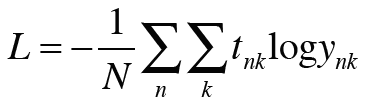
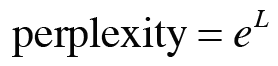

N:데이터의 총개수

tn: 원핫 벡터로 나타낸 정답 레이블

tnk: n개째 데이터의 k번째 값

ynk: 확률분포(신경망에서sms Softmax의 출력)

L: 신경망의 손실. 교차 엔트로피 오차를 뜻하는 식과 같은 식

In [69]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb



# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)



In [70]:
corpus

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        27,  24,  39,  26,  40,  41,  42,  26,  43,  32,  44,  45,  46,
        24,  47,  26,  27,  28,  29,  48,  49,  41,  42,  50,  51,  52,
        53,  54,  55,  35,  36,  37,  42,  56,  57,  58,  59,  24,  35,
        60,  42,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  35,
        71,  72,  42,  73,  74,  75,  35,  46,  42,  76,  77,  64,  78,
        79,  80,  27,  28,  81,  82,  83,  24,  32,  61,  84,  26,  40,
        85,  26,  62,  78,  86,  32,  26,  87,  88,  89,  90,  64,  78,
        91,  92,  93,  94,  95,  96,  97,  82,  98,  24,  26,  99,  32,
       100,  42, 101, 102,  26, 103,  93, 104,  66, 105, 106, 107,  26,
       108, 109,  26,  67,  68, 108,  27,  24, 110, 111, 112, 113,  83,
        79,  80,  35, 114,  81,  32, 115, 116, 117, 108, 118, 11

In [71]:
corpus[:corpus_size]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        27,  24,  39,  26,  40,  41,  42,  26,  43,  32,  44,  45,  46,
        24,  47,  26,  27,  28,  29,  48,  49,  41,  42,  50,  51,  52,
        53,  54,  55,  35,  36,  37,  42,  56,  57,  58,  59,  24,  35,
        60,  42,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  35,
        71,  72,  42,  73,  74,  75,  35,  46,  42,  76,  77,  64,  78,
        79,  80,  27,  28,  81,  82,  83,  24,  32,  61,  84,  26,  40,
        85,  26,  62,  78,  86,  32,  26,  87,  88,  89,  90,  64,  78,
        91,  92,  93,  94,  95,  96,  97,  82,  98,  24,  26,  99,  32,
       100,  42, 101, 102,  26, 103,  93, 104,  66, 105, 106, 107,  26,
       108, 109,  26,  67,  68, 108,  27,  24, 110, 111, 112, 113,  83,
        79,  80,  35, 114,  81,  32, 115, 116, 117, 108, 118, 11

In [72]:
int(max(corpus) + 1)

418

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 407.01
| 에폭 2 | 퍼플렉서티 272.55
| 에폭 3 | 퍼플렉서티 226.72
| 에폭 4 | 퍼플렉서티 217.59
| 에폭 5 | 퍼플렉서티 208.72
| 에폭 6 | 퍼플렉서티 205.07
| 에폭 7 | 퍼플렉서티 200.49
| 에폭 8 | 퍼플렉서티 197.45
| 에폭 9 | 퍼플렉서티 192.97
| 에폭 10 | 퍼플렉서티 193.54
| 에폭 11 | 퍼플렉서티 189.55
| 에폭 12 | 퍼플렉서티 192.37
| 에폭 13 | 퍼플렉서티 190.30
| 에폭 14 | 퍼플렉서티 191.26
| 에폭 15 | 퍼플렉서티 190.60
| 에폭 16 | 퍼플렉서티 186.96
| 에폭 17 | 퍼플렉서티 185.40
| 에폭 18 | 퍼플렉서티 182.08
| 에폭 19 | 퍼플렉서티 183.28
| 에폭 20 | 퍼플렉서티 184.00
| 에폭 21 | 퍼플렉서티 182.10
| 에폭 22 | 퍼플렉서티 177.17
| 에폭 23 | 퍼플렉서티 174.52
| 에폭 24 | 퍼플렉서티 176.43
| 에폭 25 | 퍼플렉서티 173.20
| 에폭 26 | 퍼플렉서티 172.32
| 에폭 27 | 퍼플렉서티 168.01
| 에폭 28 | 퍼플렉서티 167.30
| 에폭 29 | 퍼플렉서티 163.52
| 에폭 30 | 퍼플렉서티 158.26
| 에폭 31 | 퍼플렉서티 158.52
| 에폭 32 | 퍼플렉서티 152.28
| 에폭 33 | 퍼플렉서티 152.38
| 에폭 34 | 퍼플렉서티 147.95
| 에폭 35 | 퍼플렉서티 146.52
| 에폭 36 | 퍼플렉서티 141.89
| 에폭 37 | 퍼플렉서티 137.10
| 에폭 38 | 퍼플렉서티 133.37
| 에폭 39 | 퍼플렉서티 128.21
| 에폭 40 | 퍼플렉서티 123.94
| 에폭 41 | 퍼플렉서티 122.20
| 에폭 42 | 퍼플렉서티 116.05
| 에폭 43 | 퍼플렉서티 110

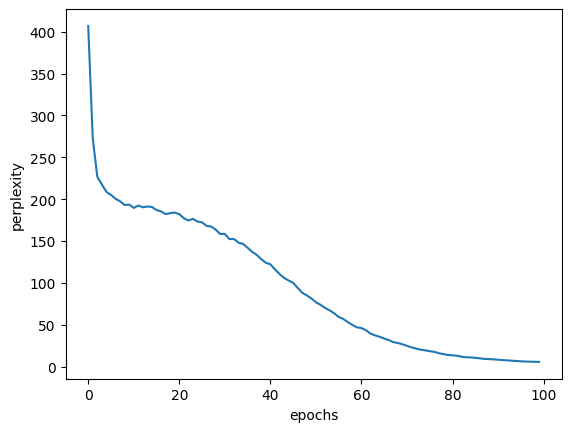

In [32]:
xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()